In [ ]:
# run this cell in colab
# !echo "deb http://downloads.skewed.de/apt bionic main" >> /etc/apt/sources.list
# !apt-key adv --keyserver keys.openpgp.org --recv-key 612DEFB798507F25
# !apt-get update
# !apt-get install python3-graph-tool python3-cairo python3-matplotlib

In [54]:
import jax
import jax.numpy as jnp
from jax import jit, random, grad

In [1]:
#participation ratio
def comp_d(X,d_sim,start_idx=0):
    X = X[start_idx:d_sim]
    X_bar = X.mean(0)
    X_ = X - X_bar
    C = X_.T.dot(X_)/(d_sim - start_idx + 1)
    return np.trace(C)**2/np.trace(C.dot(C))


In [2]:
import itertools
from tqdm import tqdm
import pickle
import json

from utils import *
from scipy.stats import genpareto,genexpon
import numpy as np
import matplotlib.pyplot as plt
#import pandas as pd
from graph_tool.generation import random_graph
from graph_tool.spectral import adjacency


In [17]:
%matplotlib inline

## Random number generators:
<ol>
    <li> <strong>SF distribution</strong>: obtained by discretization to the nearest integer of the continuous Pareto distribution
$P(K) = \frac{(\gamma - 1)a^{\gamma -1}}{K^\gamma}$ 
which we get using the Generalized pareto distribution $$P(K) = \frac{1}{\sigma}\left(1 + \frac{\xi(K - \mu)}{\sigma}\right)^{\left(-\frac{1}{\xi} - 1\right)} \stackrel{*}{=}  \frac{(\gamma - 1)a^{\gamma -1}}{K^\gamma}$$
$*\text{ by setting } \xi = \frac{1}{\gamma -1},~ \sigma = \frac{a}{\gamma -1}, \mu = a$

    
which can be generated using `scipy.stats.genpareto(c=1/(gamma-1), scale=a/(gamma-1), loc=a)`

the average connectivity $<K>$ can be calculate theoritically $\mathbb{E}\left[K\right] = \mu + \frac{\sigma}{1-\xi} \stackrel{*}{=} \frac{a}{\gamma -2}$</li>
    
  <li><strong>Binomial distribution</strong>: parametrized by the average connectivity $<K>$ we generate from $K \sim B(N, \frac{<k>}{N})$ 
      
which can be generated using `numpy.random.binomial(n=N, p=mean_k/N)`
      
</li>
  <li><strong>Exponential distribution</strong>: obtained by discretization to the nearest integer of the continuous Exponential distribution $P(k) = \frac{1}{\beta} \exp(-\frac{k}{\beta})$</li>
    
which can be generated using `numpy.random.exponential(scale=beta)`

</ol>   

In [3]:
def degree_rv(dist, gamma=None, a=None, beta=None, mean_k=None, N=None):
    if dist == 'sf':
        assert gamma is not None, "gamma must be specified for SF distribution"
        assert a is not None, "mu must be specified for SF distribution"
        return genpareto.rvs(c = 1/(gamma-1), scale=a/(gamma-1), loc=a)
    elif dist == 'binom':
        assert mean_k is not None, "mean_k must be specified for binom distribution"
        assert N is not None, "N must be specified for binom distribution"
        return np.random.binomial(n=N, p=mean_k/N)
    elif dist == 'exp':
        assert beta is not None, "N must be specified for binom distribution"
        return np.random.exponential(scale=beta)

- Stress:   $$s = |y - y^*| = |b^Tx - y^*|$$
- Mismatch:
$$\mathcal{M}(s) = \frac{\mathcal{M}_0}{2}\left[1 + \tanh\left(\frac{s - \epsilon}{\mu}\right)\right]$$

In [4]:
def stress(b, x,target = 0):
    return np.abs(np.dot(b,x) - target)
                  
def Mismatch(s, M_0, mu, eps):
    return (M_0/2) * (1 + np.tanh((s - eps)/mu))

## Run trial:
- Initialize $b \sim \mathcal{N}(m_b, \frac{1}{g_0^2 c N}\alpha)$
- Initialize $J_0 \sim  \mathcal{N}(0, \frac{1}{g_0^2 <k>}) $

In [5]:
def init_b(N = 1500, c = 0.2, alpha = 100.0, g_0 = 10.0, m_b = 0.0):
    b = np.zeros(N,)
    cN=int(np.round(N*c)) #number of non-zeroes 
    idxs = np.random.permutation(range(N))[:cN] #choose cN indicies out of N at random 
    g_b = (1/g_0)*np.sqrt(alpha/cN);
    b[idxs] = m_b + g_b*np.random.randn(cN)
    
    return b

def init_J(T, g_0=10):
    active_idxs = np.where(T!=0) #the only connections to update
    N_W_n_z = np.sum(T) # number of active connections
    avg_k = np.sum(T,1).mean() # average connectivity <K>
    
    W_int = np.zeros_like(T,dtype=np.float)
    W_int[active_idxs] = (g_0/np.sqrt(avg_k))*np.random.randn(N_W_n_z,)
    return W_int

def F(J, x):
    return np.dot(J, np.tanh(x)) - x



In [6]:
def run_trial(T, x_0 = None, W_0=None,  N=1500, g_0=10, b_alpha=100, m_b =0, sparsity=0.2, g_w=10, target=0, D=1e-3, eps=3, mu=0.01, M_0=4, t_int=0, t_max=2000, dt=0.1, T_stop=100, tol=1e-2):
    """
    run dynamics for a given ensemble 
  
    Parameters:
    T: NXN adjacency matrix for a predefined ensemble
    N: network size
    g_0: matrix gain for the vector b initialization
    b_alpha: parameter determining the scale of phenotype fluctuations
    m_b: mean of b[i]
    sparsity (c): fraction of non-zero elements in b
    g_w:matrix gain for J initilization
    target: y*
    D: The amplitude of the random walk
    eps,mu,M_0: parameters for the Mismatch function
    t_int: initial time for the simluation
    dt: the step-size for the dynamics
    t_max: if network does not converge end simulation at t=t_max
    T_stop: if network output y~y* for T_stop time units, then network converged.
    tol: Ms(|y-y*|)< tol is regarded as success to converge

    Returns:
    is_success: 1 if converged, 0 otherwise.
  
    """
    
    
    # initialize b
    b = init_b(N=N, alpha=b_alpha, g_0=g_0,m_b=m_b)
    
    
    # initialize J
    if W_0 is not None:
        W_rec = W_0
    else:
        W_rec = init_J(T,g_0)
        
        

    
    #active indicies (used for updating weights)
    N_W_n_z = np.sum(T)
    active_idxs = np.where(T!=0)
    
    # trial params
    T_sim = round(t_max/dt)+1;

    s = np.zeros((T_sim,)) #Will hold stress at all timesteps (not essensial)
    M_s = np.zeros((T_sim,)) #Will hold mismatch function at all timesteps - useful for stopping creterion
    is_sucess = 0 #will be set to 1 in case the network converges
    
    
    # initialize x
    X = np.zeros((T_sim,N))
    if x_0 is not None:
        X[0] = x_0
    else:
        X[0] = 10 *np.random.randn(N)
        
    #run trial
    for i in range(T_sim-1):
        # calculate mismatch
        s[i] = stress(b, X[i], target=0)
        M_s[i] = Mismatch(s[i], M_0, mu, eps)
        
        #run dynamics
        X[i+1] = X[i] + dt*F(W_rec,X[i])#(np.dot(W_rec,np.tanh(X[i])) - X[i])
        
        # update weights - EA
        delta = np.sqrt(M_s[i]*dt*D)*np.random.randn(N_W_n_z,)
        W_rec[active_idxs] = W_rec[active_idxs] + delta
        
        #stopping creterion:
        if i*dt> T_stop:
            if ~np.any(M_s[i-int((T_stop/dt)):i] > tol):
                is_sucess = 1
                break
    
    return is_sucess, X, i+1

# Calcuate CF for different ensembles:
- Mismatch function parameters: $\mathcal{M}_0 =4,~ \epsilon=3,~ \mu = 0.01$
- dynamics parameters: $D = 10^{-3},~ dt =0.1,~ tol = 10^{-2}$
- target: $y^* = 0$
- Recurrent weights initilzation $J$: $g_w = 10$
- readout weights initialization $b$: $g_0 = 10,~ c=0.2,~ \alpha=100$


In [7]:
#params for first figure
# dist params
gamma, a = 2.4,1
mean_k, beta = 3.5, 3.5

# output
target = 0

# connectivity params
N=1500
g_0 = 10
g_w = 10

# optimizer params
D = 1e-3

#Mismatch function parameters:
eps = 3 #epsilon tolerance of stress -  if the stress is below eps_s it is zero or very low
mu = 0.01 #steepness (mu) of f(s) in its sigmoidal form M(s)=2a(1-tanh((s-eps)/mu))
M_0 = 4;  #stauration value (a) of f(s) in its sigmoidal form M(s)=(a/2)(1-tanh((s-eps)/mu))

In [8]:
dists = ['sf','binom','exp']
all_combinations = [each_permutation for each_permutation in itertools.product(dists, dists)]
all_combinations

[('sf', 'sf'),
 ('sf', 'binom'),
 ('sf', 'exp'),
 ('binom', 'sf'),
 ('binom', 'binom'),
 ('binom', 'exp'),
 ('exp', 'sf'),
 ('exp', 'binom'),
 ('exp', 'exp')]

In [154]:
n_trials = 100
CF = {} #Convergence fraction for each ensemble
PR = {} # Participation Ratio for each ensemble
for (out_dist, in_dist) in all_combinations:

    tot_s = 0
    d = np.zeros((n_trials,))
    for i in tqdm(range(n_trials)):
        g = random_graph(N, deg_sampler=lambda:(degree_rv(dist=in_dist,gamma=gamma,beta=beta, a=a,mean_k=mean_k,N=N)
                                            ,degree_rv(dist=out_dist,gamma=gamma,beta=beta, a=a,mean_k=mean_k,N=N)))
    #topology matrix
        T = np.array(adjacency(g).todense()).astype(np.uint)
        is_s,X,sim_idx = run_trial(T)
        tot_s += is_s
        d[i] = comp_d(X,sim_idx)
    CF[(out_dist, in_dist)] = tot_s/n_trials
    PR[(out_dist, in_dist)] = d
    print(out_dist, in_dist, tot_s/n_trials, np.mean(d))
    

100%|████████████████████████████████████| 100/100 [47:03:51<00:00, 1694.31s/it]


binom exp 0.0 31.91892336124784


100%|█████████████████████████████████████████| 100/100 [20:23<00:00, 12.23s/it]


exp sf 0.3 15.418411345937523


100%|█████████████████████████████████████| 100/100 [18:10:35<00:00, 654.35s/it]


exp binom 0.01 27.068979658764935


100%|█████████████████████████████████████████| 100/100 [24:39<00:00, 14.80s/it]

exp exp 0.3 16.07023976116135


In [163]:
# # save results:
# with open('CF_results.txt','w') as f:
#     json.dump({str(k):v for k,v in CF.items()},f)
    
# with open('PR_results.pickle', 'wb') as handle:
#     pickle.dump(PR, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [168]:
# # Load data 
with open('CF_results.txt', 'r') as handle:
     CF = json.load(handle)

with open('PR_results.pickle', 'rb') as handle:
     PR = pickle.load(handle)

In [13]:
all_combinations

[('sf', 'sf'),
 ('sf', 'binom'),
 ('sf', 'exp'),
 ('binom', 'sf'),
 ('binom', 'binom'),
 ('binom', 'exp'),
 ('exp', 'sf'),
 ('exp', 'binom'),
 ('exp', 'exp')]

5it [35:17, 423.58s/it]


KeyboardInterrupt: 

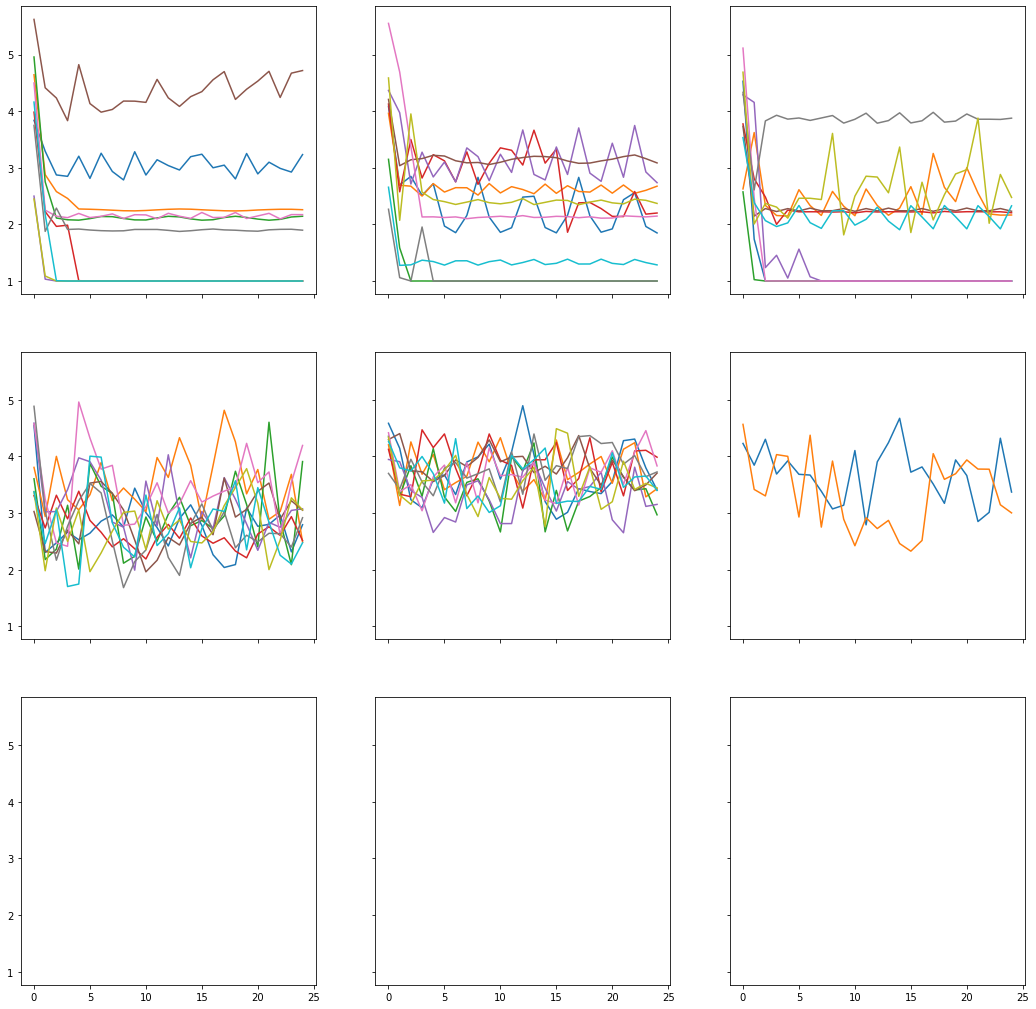

In [28]:
T_max = 500
time_window = 200
n_trials = 10
fig, axs = plt.subplots(3,3, sharex=True,sharey=True, figsize=(3*6,3*6))
idxs = np.arange(0,T_max*10, time_window)
for i,(out_dist, in_dist) in tqdm(enumerate(all_combinations)):
    
    for _ in range(n_trials):
        g = random_graph(N, deg_sampler=lambda:(degree_rv(dist=in_dist,gamma=gamma,beta=beta, a=a,mean_k=mean_k,N=N)
                                                ,degree_rv(dist=out_dist,gamma=gamma,beta=beta, a=a,mean_k=mean_k,N=N)))
        #topology matrix
        T = np.array(adjacency(g).todense()).astype(np.uint)
        X,W = run_dynamics(T,t_max=T_max)
        y = [comp_d(X, idx+time_window, idx) for idx in idxs]    
        axs[i//3,i%3].plot(y)
  

for ax, col in zip(axs[0], dists):
    ax.set_title(col)

for ax, row in zip(axs[:,0], dists):
    ax.set_ylabel(row, rotation=0, size='large')


In [26]:
idxs

25

In [11]:
n_trials = 50
CF = {} #Convergence fraction for each ensemble
PR = {} # Participation Ratio for each ensemble
for (out_dist, in_dist) in all_combinations:

    tot_s = 0
    d = np.zeros((n_trials,))
    for i in tqdm(range(n_trials)):
        g = random_graph(N, deg_sampler=lambda:(degree_rv(dist=in_dist,gamma=gamma,beta=beta, a=a,mean_k=mean_k,N=N)
                                            ,degree_rv(dist=out_dist,gamma=gamma,beta=beta, a=a,mean_k=mean_k,N=N)))
    #topology matrix
        T = np.array(adjacency(g).todense()).astype(np.uint)
        X,_ = run_dynamics(T, t_max = 500)
        d[i] = comp_d(X,5000)
    
    PR[(out_dist, in_dist)] = d
    print(out_dist, in_dist, tot_s/n_trials, np.mean(d))
    

 48%|████████████████████▋                      | 24/50 [00:56<01:01,  2.35s/it]


KeyboardInterrupt: 

In [10]:
def run_dynamics(T, N=1500, g_0=10, b_alpha=100, m_b =0, sparsity=0.2, target=0, eps=3, mu=0.01, M_0=2, t_int=0, t_max=2000, dt=0.1):
    """
    run dynamics for a given ensemble ()
  
    Parameters:
    T: NXN adjacency matrix for a predefined ensemble
    N: network size
    g_0: matrix gain for the vector b initialization
    b_alpha: parameter determining the scale of phenotype fluctuations
    m_b: mean of b[i]
    sparsity (c): fraction of non-zero elements in b
    t_int: initial time for the simluation
    dt: the step-size for the dynamics
    t_max: if network does not converge end simulation at t=t_max

    Returns:
    X: state vector for each trial
    W_rec: The connectivity matrix
  
    """
    
    
    # initialize b
    b = init_b(N, sparsity, b_alpha, g_0, m_b)
    
    # initialize J
    W_rec = init_J(T, g_0)
        
    # trial params
    T_sim = round(t_max/dt)+1;
 
        # initialize x
    X = np.zeros((T_sim,N))
    X[0] = 10 *np.random.randn(N)
    #run trial
    for i in range(T_sim-1):
        X[i+1] = X[i] + dt*F(W_rec,X[i])
    
    return X,W_rec

In [260]:
import pandas as pd

Text(0, 0.5, 'Particioation Ratio d')

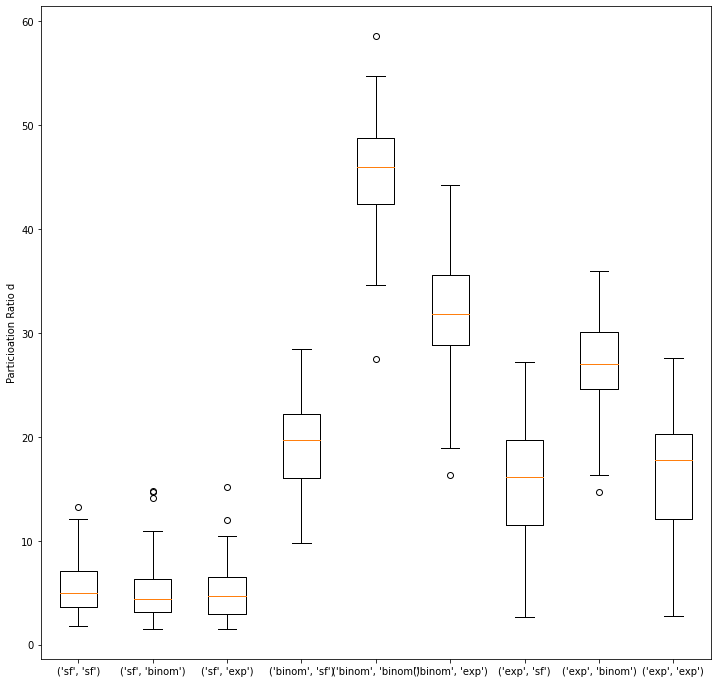

In [261]:
fig, ax = plt.subplots(figsize = (12,12))
df = pd.DataFrame(PR)
ax.boxplot(df,labels=df.columns);
ax.set_ylabel('Particioation Ratio d')
#ax = pd.DataFrame(D).boxplot()

Text(0, 0.5, 'Particioation Ratio d')

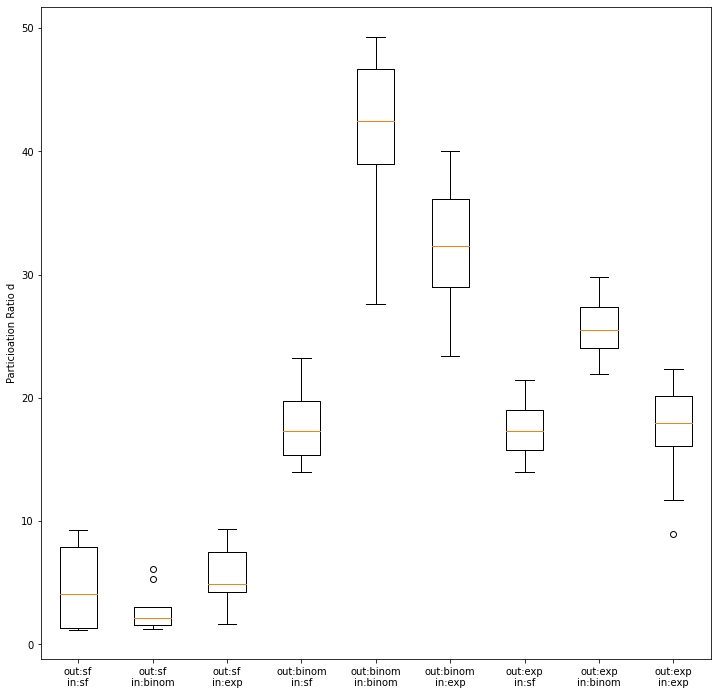

In [175]:
fig, ax = plt.subplots(figsize = (12,12))
df = pd.DataFrame(D)
ax.boxplot(df,labels=v);
ax.set_ylabel('Particioation Ratio d')
#ax = pd.DataFrame(D).boxplot()

## Check correlation between participation ratio and convergence fraction
- run Dynamics without modifying the connecticity 
- calculate participation ratio 
- use same ensemble and initial conditions ($x_0, J_0$) and compute CF.

In [416]:
in_dist, out_dist = 'binom', 'sf'
g = random_graph(N, deg_sampler=lambda:(degree_rv(dist=in_dist,gamma=gamma,beta=beta, a=a,mean_k=mean_k,N=N)
                                            ,degree_rv(dist=out_dist,gamma=gamma,beta=beta, a=a,mean_k=mean_k,N=N)))
#topology matrix
T = np.array(adjacency(g).todense()).astype(np.uint)
res_cf,res_d = {},{}
for i in range(20):
    X,W_0 = run_dynamics(T) # run dynamics without modifying J, returns X[t] and J_0
    d = comp_d(X,idx) # compute PR
    # calculate CF 
    is_s_l = []
    ds = []
    for i in range(20):
        is_, Y,sim_idx = run_trial(T,x_0=X[0],W_0=W_0) #use similar initial conditions 
        d2 = comp_d(Y,sim_idx)
        ds.append(d2)
        is_s_l.append(is_)
    res_cf[d] = is_s_l
    res_d[d] = ds

In [419]:
res_d

{5.037033873685642: [11.002534561000418,
  7.94948977102333,
  6.201790841656616,
  7.48560657597205,
  3.744098062932751,
  4.425053654495461,
  5.787449912459824,
  3.7957978066860516,
  8.406564513090167,
  8.27695264511078,
  7.999121630873088,
  8.803103326747763,
  4.154529693477914,
  2.4804742113158937,
  2.8749261483722086,
  1.5595037097856845,
  3.0370151631597126,
  5.781360276067527,
  5.787353872659378,
  4.122914457477062],
 5.478559647726411: [11.637698679940968,
  10.212238548837751,
  10.740095572391466,
  6.473502587866671,
  6.042052010843326,
  5.6938271508395975,
  4.477269887573203,
  5.038282860630083,
  9.601211092124972,
  5.529198097463706,
  8.396262472022505,
  7.384904813960935,
  3.6246031244572507,
  5.926230025501106,
  3.4592237214029264,
  4.049049103583348,
  5.9484715953722,
  5.794173659089819,
  4.237902528306891,
  5.151331663169983],
 4.6858061954658154: [8.030449440764635,
  5.339829083095894,
  5.328810118648098,
  4.541800981678411,
  2.24179

In [420]:
{k:np.mean(v) for k,v in res_d.items()}

{5.037033873685642: 5.6837820417181835,
 5.478559647726411: 6.470876459768935,
 4.6858061954658154: 5.204752149269922,
 4.1387115258788265: 5.181752490775194,
 2.415684200339416: 4.2241978217493195,
 5.361755984982819: 7.172102913179081,
 5.651684903934063: 4.596813383992307,
 1.9334745520064678: 3.799779302189566,
 5.341767723170125: 5.888069349189895,
 4.55021747602068: 5.754790368558867,
 2.578127872643904: 5.676156720250921,
 3.8112670254242884: 5.790204173747105,
 2.4012262221244653: 7.747445834769373,
 3.417841994243714: 6.423837508788298,
 2.736084794132313: 6.595700695900204,
 7.251013233910765: 5.106564859092099,
 6.75113553820146: 7.344490855064824,
 3.0883521849483975: 7.003722908037801,
 4.000606925800481: 6.122705430406775,
 3.582765665482274: 5.356228301651532}

## TODO Check change in connectivity:
- $\Delta W = W_T - W_0$
- Compute rank (use SVD), and change in spectrom

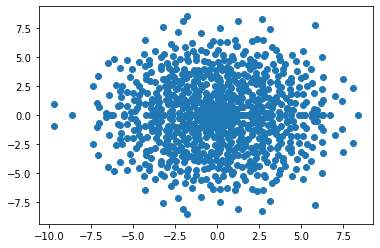

In [319]:
lambda_0 = np.linalg.eigvals(W_0)
plt.scatter(np.real(lambda_0),np.imag(lambda_0))

In [323]:
np.mean(lambda_T > 0)

0.484

In [324]:
dW = W_T-W_0

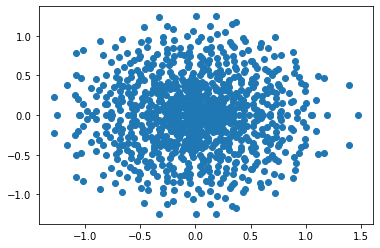

In [325]:
lambda_T = np.linalg.eigvals(dW)
plt.scatter(np.real(lambda_T),np.imag(lambda_T))

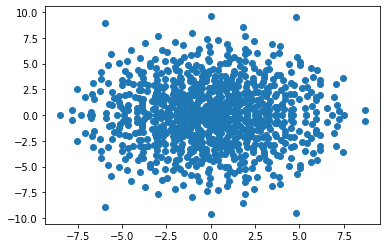

In [315]:
x = np.linalg.eigvals(W_rec)
plt.scatter(np.real(x),np.imag(x))

## Exploratory adaptation on hubs connection
- alter only connections out of the top k hubs
- add self loops to top k hubs, alter only these connections (total k connections)

In [340]:
def run_trial_hub(T,top_k=1, N=1500, g_0=10, b_alpha=100, m_b =0, sparsity=0.2, g_w=10, target=0, D=1e-3, eps=3, mu=0.01, M_0=2, t_int=0, t_max=2000, dt=0.1, T_stop=100, tol=1e-2):
    """
    run dynamics for a given ensemble 
  
    Parameters:
    T: NXN adjacency matrix for a predefined ensemble
    N: network size
    g_0: matrix gain for the vector b initialization
    b_alpha: parameter determining the scale of phenotype fluctuations
    m_b: mean of b[i]
    sparsity (c): fraction of non-zero elements in b
    g_w:matrix gain for J initilization
    target: y*
    D: The amplitude of the random walk
    eps,mu,M_0: parameters for the Mismatch function
    t_int: initial time for the simluation
    dt: the step-size for the dynamics
    t_max: if network does not converge end simulation at t=t_max
    T_stop: if network output y~y* for T_stop time units, then network converged.
    tol: Ms(|y-y*|)< tol is regarded as success to converge

    Returns:
    is_success: 1 if converged, 0 otherwise.
  
    """
    
    
    # initialize b
    b = np.zeros(N,)
    n=int(np.round(N*sparsity))
    idxs = np.random.permutation(range(N))[:n]
    g_b = (1/g_0)*np.sqrt(b_alpha/n);
    b[idxs] = m_b + g_b*np.random.randn(n)
    
    # initialize J
    active_idxs = np.where(T!=0) #the only connections to update
    N_W_n_z = np.sum(T) # number of active connections
    avg_k = np.sum(T,1).mean() # average connectivity
    W_int = np.zeros((N,N))
    W_int[active_idxs] = (g_w/np.sqrt(avg_k))*np.random.randn(N_W_n_z,)
    W_rec = W_int.copy()
    
    
    
    idxs_from_hub = np.where(T[:,idx_hub]!=0)[0]
    tot_N_z = len(idxs_from_hub)
    # trial params
    T_sim = round(t_max/dt)+1;
    is_sucess = 0 #will be set to 1 in case the network converges
    s = np.zeros((T_sim,)) #Will hold stress at all timesteps (not essensial)
    M_s = np.zeros((T_sim,)) #Will hold mismatch function at all timesteps - useful for stopping creterion
    #X_z = X - X.mean()
    #C = X_z.dot(X_z.T)
    
        # initialize x
    X = np.zeros((T_sim,N))
    X[0] = 10 *np.random.randn(N)
    #run trial
    for i in range(T_sim-1):
        s[i] = stress(b, X[i], target=0)
        M_s[i] = 2*(1 + np.tanh((s[i] - eps)/mu))
        
        X[i+1] = X[i] + dt*(np.dot(W_rec,np.tanh(X[i])) - X[i])
        #X_z = X - X.mean()
        #C += X_z.dot(X_z.T)
        delta = np.sqrt(M_s[i]*dt*D)*np.random.randn(tot_N_z,)
        W_rec[idxs_from_hub,idx_hub] = W_rec[idxs_from_hub,idx_hub] + delta
        
        if i*dt> T_stop:
            if ~np.any(M_s[i-int((T_stop/dt)):i] > tol):
                is_sucess = 1
                break
    
    #d = np.trace(C)**2/np.trace(C.dot(C))
    return is_sucess, X, i+1 

In [ ]:
# def run_trial(T, N=1500, g_0=10, b_alpha=100, m_b =0, sparsity=0.2, g_w=10, target=0, D=1e-3, eps=3, mu=0.01, M_0=2, t_int=0, t_max=2000, dt=0.1, T_stop=100, tol=1e-2):
#     """
#     run dynamics for a given ensemble 
  
#     Parameters:
#     T: NXN adjacency matrix for a predefined ensemble
#     N: network size
#     g_0: matrix gain for the vector b initialization
#     b_alpha: parameter determining the scale of phenotype fluctuations
#     m_b: mean of b[i]
#     sparsity (c): fraction of non-zero elements in b
#     g_w:matrix gain for J initilization
#     target: y*
#     D: The amplitude of the random walk
#     eps,mu,M_0: parameters for the Mismatch function
#     t_int: initial time for the simluation
#     dt: the step-size for the dynamics
#     t_max: if network does not converge end simulation at t=t_max
#     T_stop: if network output y~y* for T_stop time units, then network converged.
#     tol: Ms(|y-y*|)< tol is regarded as success to converge

#     Returns:
#     is_success: 1 if converged, 0 otherwise.
  
#     """
    
    
#     # initialize b
#     b = jnp.zeros(N,)
#     n=int(jnp.round(N*sparsity))
#     idxs = random.permutation(key,jnp.arange(N))[:n]
#     g_b = (1/g_0)*jnp.sqrt(b_alpha/n);
#     b = jax.ops.index_update(b,idxs,m_b g_b*jax.random.normal(key, shape=(n,)))

    
#     # initialize J
#     #active_idxs = np.where(T!=0) #the only connections to update
#     N_W_n_z = jnp.sum(T) # number of active connections
#     avg_k = np.sum(T,1).mean() # average connectivity
#     J = (g_w/np.sqrt(avg_k))* jax.random.normal(key, shape = T.shape)
#     J = J*T
    
#     # initialize x
#     X = 10*jax.random.normal(key, shape=(N,))
    
#     # trial params
#     T_sim = round(t_max/dt)+1;
#     is_sucess = 0 #will be set to 1 in case the network converges
#     s = jnp.zeros((T_sim,)) #Will hold stress at all timesteps (not essensial)
#     M_s = jnp.zeros((T_sim,)) #Will hold mismatch function at all timesteps - useful for stopping creterion
#     C = 
#     #run trial
#     for i in range(T_sim-1):
#         s = jax.ops.index_update(s, i, stress(b, X, target=0))
#         M_s = jax.ops.index_update(M_s,i, M(s[i]))
        
#         X = X + dt*F(J,X)
#         delta = np.sqrt(M_s[i]*dt*D)*jax.random.normal(key=key, shape=(T.shape)) * I
#         J += delta
        
#         if i*dt> T_stop:
#             if ~jnp.any(M_s[i-int((T_stop/dt)):i] > tol):
#                 is_sucess = 1
#                 break
#     return is_sucess

# Increase task complexity
- 2 fixed points